# Fundamentals of Machine Learning - Exercise 6

Johannes Kammerer, Zhao Sun, Tong Yu

## 3 Denoising of a CT image (11 points)

In [78]:
# import
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, diags, vstack, hstack
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
# construct matrix
def construct_X(M, alphas, Np = None, tau = 0, no_angles = None):
    '''
    Constructs sparse matrix X
    M: object dimension D=MxM
    alphas: list of angles
    Np: # sensor pixels
    '''    
    if Np == None:
        Np = (np.ceil(np.sqrt(2)*M)//2 * 2 + 1).astype(int) # rounds up to next odd integer
    #assert Np-1 >= np.sqrt(2)*(M-1) # for projection
    D = M**2
    N = len(alphas)*Np
    weights = []
    i_indices = []
    j_indices = []
    for io in range(len(alphas)):
        a = np.deg2rad(alphas[io])
        jb, ja = np.mgrid[0:M, 0:M]
        ja = ja.flatten()
        jb = jb.flatten()
        a0, b0 = -(M-1)/2, -(M-1)/2
        C0 = a0 + ja
        C1 = b0 + jb
        C = np.column_stack((C0, C1)).T
        n = np.column_stack((np.cos(a), -np.sin(a)))
        s0 = (Np-1)/2
        p = n@C + s0
        plow = np.floor(p)
        phigh = plow + 1
        Xlow = phigh-p
        Xhigh = p-plow
        weights = np.concatenate((weights, Xlow, Xhigh), axis=None)
        i_indices = np.concatenate((i_indices, plow + Np*io, phigh + Np*io), axis=None)
        j_indices = np.concatenate((j_indices, np.arange(D), np.arange(D)), axis=None)
     
    X = coo_matrix((weights, (i_indices, j_indices)), shape = (N, D), dtype = np.float32)
    if tau > 0:  
        diagonals = np.repeat(np.sqrt(tau), repeats = D)
        diagT = diags(diagonals)
        X = vstack([X, diagT])
    #print(X.shape)
    return X

In [108]:
X = construct_X(M = 10, alphas = [-33, 1, 42], tau = 1)
Xar = X.toarray()

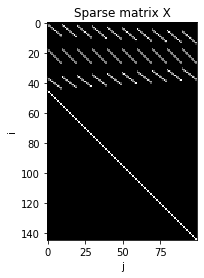

In [109]:
plt.imshow(Xar, cmap="gray")
plt.title('Sparse matrix X')
plt.xlabel('j')
plt.ylabel('i')
plt.show()

### Solution with Ridge Regression

In [45]:
# global variables
No = 179
Np = 275
M = 195
D = M**2

In [62]:
def reconstruct(taus, no_angles = 64, tol = 1e-03):
    # initialize
    sol = []
    
    # load data
    alphas_195 = np.load('hs_tomography/alphas_195.npy')
    y_195 = np.load('hs_tomography/y_195.npy')

    for tau in taus:
        # construct sparse matrix in COO and CSC format
        COO_195 = construct_X(M = 195, alphas = alphas_195, Np = 275, tau=tau)
        CSC_195 = COO_195.tocsc()

        # select no_angles projection angles
        pos = np.arange(No*Np).reshape((No,Np))
        ios = np.sort(np.random.choice(No, no_angles, replace = False))
        pos = pos[ios,:].flatten()
        y = y_195[pos]
        Xpos = np.concatenate((pos, np.arange(-D, 0))) if tau > 0 else pos
        CSC = CSC_195[Xpos,:]

        # extend y with D zeros
        if tau > 0:
            y_ext = np.zeros(CSC.shape[1])
            y = np.concatenate((y, y_ext))

        # solve sparse linear equation
        b = lsqr(CSC, y, atol=tol, btol=tol)[0]
        sol.append(b)
        
    return sol

In [60]:
tauvalues = [0, 1, 10, 100, 1e3, 1e4]
sol = reconstruct(taus = tauvalues, tol = 1e-05)

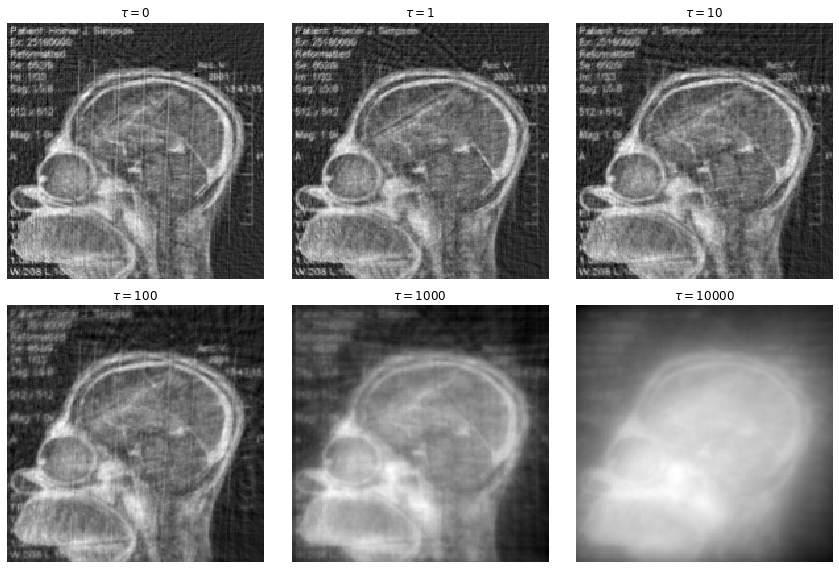

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)
for i in range(6):
    axes[i//3,i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//3,i%3].set_axis_off()
    axes[i//3,i%3].set_title(r'$\tau=%i$' %tauvalues[i])
plt.show()

<span style="font-weight: bold"><ins>Comparison: </ins> \
    We observe that for a small $\tau$ the sharpness increases because the Ridge regression descreases the noise (variance) of the solution. However, it introduces a bias in the result which can be seen in the increased brightness of the skull for large values of $\tau$. At about $\tau=1$, the bullet can be resolved best and hast the highest sharpness.</span>

### Solution with Gaussian filtering

In [95]:
filters = [0,1,2,3,5,7]
sol = []
for f in filters:
    tomo = reconstruct(taus = [0], tol = 1e-05)[0]
    sol_f = gaussian_filter(tomo, sigma=f)
    sol.append(sol_f)

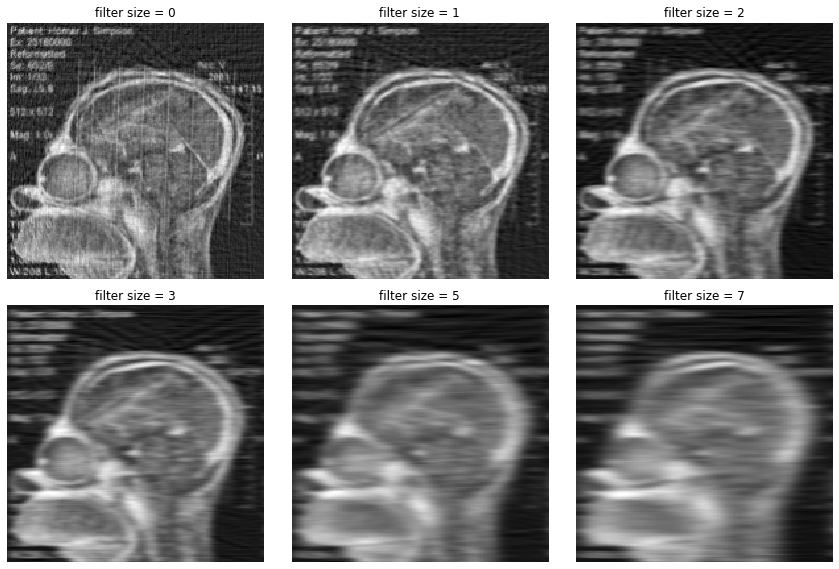

In [96]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)
for i in range(6):
    axes[i//3,i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//3,i%3].set_axis_off()
    axes[i//3,i%3].set_title('filter size = %i' %filters[i])
plt.show()

<span style="font-weight: bold"><ins>Observation: </ins>\
In the method 'gaussian filtering', each pixel is replaced by the weighted average of its neighboring pixels. The parameter $\sigma$ determines the size of the neighborhood. We observe that for $\sigma=1$, the image already becomes more blurry, but some variance has been reduced and the bullet can be resolved. For the larger $\sigma$ values, the image is more and more blurred. \
<ins>Comparison: </ins> \
In this case, the Ridge regression is superior to the gaussian filtering, because the variance seems to happen on small scales and the filtering averages over too large an area which leads to the blurred appearance. We would therefore choose the Ridge regression. \
<ins>Addition: </ins> \
We estimate the values of the parameter $\sigma$ is too large for the variance in this image. Therefore we test smaller values, too (see below). Here we find that, e.g., $\sigma=0.1$ effectively reduces the noise and increases the sharpness of the image. The bullet can be resolved properly here.</span>

In [97]:
filters = [0,0.1,0.5]
sol = []
for f in filters:
    tomo = reconstruct(taus = [0], tol = 1e-05)[0]
    sol_f = gaussian_filter(tomo, sigma=f)
    sol.append(sol_f)

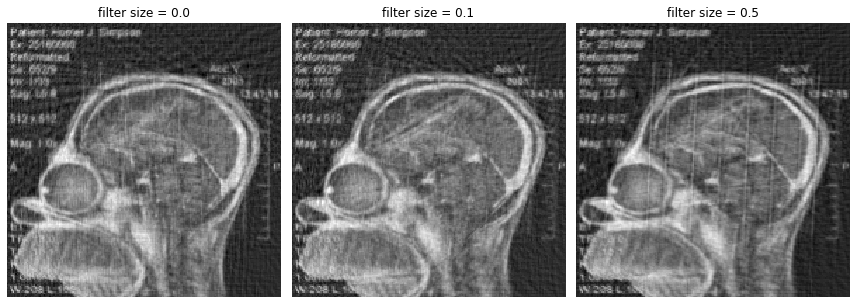

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(12,8), tight_layout=True)
for i in range(3):
    axes[i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i%3].set_axis_off()
    axes[i%3].set_title('filter size = %.1f' %filters[i])
plt.show()

### Additional stuff

In [56]:
tauvalues = [0, 1, 10, 100, 1e3, 1e4]
sol = reconstruct(taus = tauvalues)

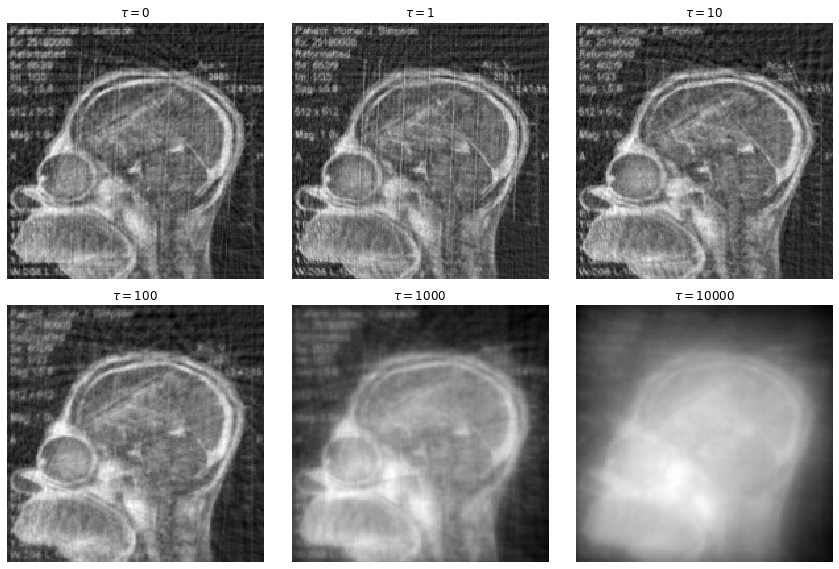

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)
for i in range(6):
    axes[i//3,i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//3,i%3].set_axis_off()
    axes[i//3,i%3].set_title(r'$\tau=%i$' %tauvalues[i])
plt.show()

In [58]:
tauvalues = [0, 1, 10, 100, 1e3, 1e4]
sol = reconstruct(taus = tauvalues, no_angles = 179)

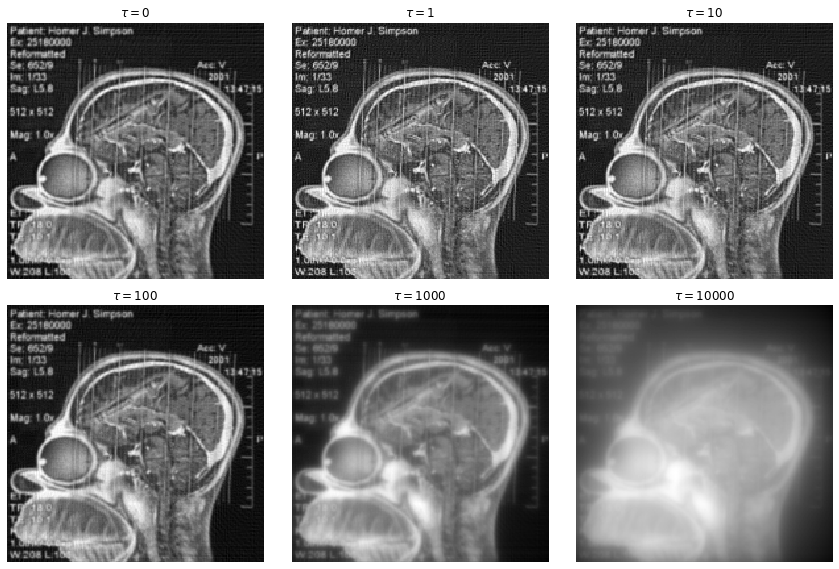

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(12,8), tight_layout=True)
for i in range(6):
    axes[i//3,i%3].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//3,i%3].set_axis_off()
    axes[i//3,i%3].set_title(r'$\tau=%i$' %tauvalues[i])
plt.show()

<span style="font-weight: bold">Observation: \
    ...</span>